<a href="https://colab.research.google.com/github/HSE-LAMBDA/DeepGenerativeModels/blob/master/homeworks/VAE-homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install comet-ml
# import comet_ml in the top of your file
from comet_ml import Experiment
    

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid


seed=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cats vs. Dogs
![](https://upload.wikimedia.org/wikipedia/ru/5/57/CatDog.GIF)
Задача домашки - научиться генерить собак, кошек ~~и котопсов~~ с помощью Conditional VAE

In [ ]:
# загрузим данные. Не забудьте принять правила соревнования! https://www.kaggle.com/c/dogs-vs-cats/rules
# !pip install --upgrade --force-reinstall --no-deps kaggle
!KAGGLE_USERNAME="hseseva" KAGGLE_KEY="5d75a4ca6f31cabb477e72ff363b1fad" kaggle competitions download -c dogs-vs-cats

# Dataset

In [ ]:
!unzip dogs-vs-cats.zip
!unzip train.zip > /dev/null

In [ ]:
from torch.utils.data import Dataset
import os
from skimage import io
import random
import numpy as np

n_classes = 2

class CatsVsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None, soft_labels=0):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(self.root_dir)
        self.soft_labels = soft_labels # soft labeling

    def __len__(self):
        return len(self.images) # число картинок в директории

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = io.imread(self.root_dir + img_name)
        mapper = {"dog" : (1. - self.soft_labels), "cat" : self.soft_labels}
        #label_onehot = F.one_hot(torch.tensor(mapper[img_name[:3]]),2)
        label_onehot = torch.Tensor([mapper[img_name[:3]], 1 - mapper[img_name[:3]]])
#         tips: 
#             1. use one-hot encoded labels. Soft one-hot encoding means one-hot labels like [0.3, 0.7]. Parameter self.soft_labels defines maximum relaxation of labels (0.0 means hard one-hot encoding)
#             2. use skimage.io to read the images 
        sample = {'image': image, 'label': label_onehot, 'filename': img_name}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

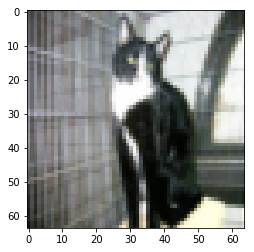

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
img_size = 64
soft_labels = 0.2
transforms_CvsD =transforms.Compose([
    
    transforms.ToPILImage(),
    #transforms.Grayscale(),
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(), # PIL Image -> Tensor    
    #transforms.Normalize((0.4883, 0.4551, 0.4169), (0.2078, 0.2032, 0.2034)),

])
dataset = CatsVsDogsDataset('train/', transforms_CvsD, soft_labels)

batch_size= 64
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size, **kwargs)

plt.imshow(dataset[25]['image'].permute(1,2,0)[:,:,:])

In [0]:
#Computing mean and std of dataset (can be used to normalize pictures)
std = torch.zeros(3)
mean = torch.zeros(3)
for i in range(len(dataset)):
    j = dataset[i]["image"]
    std += j.std((1,2))
    mean += j.mean((1,2))

In [0]:
mean_ds = mean/len(dataset)

In [0]:
std_ds = std/len(dataset)

In [0]:
std_ds

In [0]:
mean_ds

## VAE model

In [ ]:
hdim = 32

In [ ]:
class cCVAE64(nn.Module):
    def __init__(self):
        super(cCVAE64, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3,128,3,2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128,256,3,2,1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,512,3,2,1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,1024,3,2,1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.Conv2d(1024,1024,4,1,0),
            nn.ReLU(True),
            nn.Flatten( ))
        self.fc1 = nn.Linear(1024+2,512)
        self.mu = nn.Linear(512,hdim)
        self.logvar =nn.Linear(512,hdim)
        self.fc11 = nn.Linear(1024,512)
        
        
        # Decoder
        self.fc2 = nn.Linear(hdim+2, 512)
        self.fc3 = nn.Linear(512,1024)
        self.decoder =nn.Sequential(
        nn.ConvTranspose2d(1024,512,4,2,0,0,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512,256,3,2,1,1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256,256,3,2,1,1,bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256,128,3,2,1,1,bias=False),
        nn.BatchNorm2d(128),
       # nn.ReLU(True),
       nn.ConvTranspose2d(128,3,3,2,1,1),
       nn.Sigmoid())

    def encode(self, x, label):
        x = self.encoder(x)
        x = torch.cat([x, label], 1)

        x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc11(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        

    def decode(self, z, label):
        z = torch.cat([z,label], 1)
        z = F.relu(self.fc2(z))
        z = self.fc3(z)
        z = z.view(-1,1024,1,1)
        return self.decoder(z)
        

    def forward(self, x, label):
        mu, logvar = self.encode(x, label)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, label), mu, logvar
    
    def sample(self, size, label=None):
        if label is None: 
            #label = torch.randint(0,2,(size,2)).float().to(self.device)
            label = torch.randint(0,2,(64,1)).float()
            label = (label*(1-soft_labels) == 0)*soft_labels + label*(1-soft_labels)
            label = torch.cat(((torch.ones((64,1)).float() - label),label),1).to(self.device)
        sample = torch.randn(size, hdim).to(self.device)
        return model.decode(sample, label)
    
    @property
    def device(self): return next(self.parameters()).device

model = cCVAE64().to(device)
#model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight,1)

## Train VAE

In [ ]:
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="lODeHEtCf7XLaV6DJrOfugNcA",
                        project_name="hse-vae-hometask", workspace="holybayes")

In [67]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x,x,reduction = "sum")
    #BCE  = F.binary_cross_entropy(recon_x,x, reduction = "sum")
    KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

log_interval=10
epochs= 20

def train(epoch): 
    train_loss = 0
    for idx, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        img = batch["image"].cuda()
        lbl = batch["label"].float().cuda()
        recon_x, mu, logvar = model(img,lbl)
        recon_x = recon_x.view(-1,3*img_size**2)
        loss = loss_function(recon_x, img.view(-1,3*img_size**2), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if idx%log_interval == 0:
            experiment.log_metric('ae/train/loss', loss.item()/batch_size, step = (epoch-1)*(len(dataloader)) + idx)
            #print('====> Step: {} Loss: {:.4f}'.format(idx, loss.item()/batch_size))
    if epoch % 30 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, "model_final.pt")

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    

for epoch in range(1, epochs + 1):
    train(epoch)
    with torch.no_grad():
        model.eval()
        sample = model.sample(64).cpu()
        #log_img = make_grid(sample.view(-1,3,img_size,img_size)*std_ds.view(1,3,1,1) + mean_ds.view(1,3,1,1)).permute((1,2,0)) #if image was normalized
        log_img = make_grid(sample.view(-1,3,img_size,img_size)).permute((1,2,0))
        experiment.log_image(log_img,name='vae/sample',step=epoch)


====> Epoch: 1 Average loss: 190.7976
====> Epoch: 2 Average loss: 190.3444
====> Epoch: 3 Average loss: 190.1994
====> Epoch: 4 Average loss: 190.0100
====> Epoch: 5 Average loss: 189.5498
====> Epoch: 6 Average loss: 189.1558
====> Epoch: 7 Average loss: 188.9956
====> Epoch: 8 Average loss: 189.0948
====> Epoch: 9 Average loss: 188.7986
====> Epoch: 10 Average loss: 188.9127
====> Epoch: 11 Average loss: 187.3887
====> Epoch: 12 Average loss: 188.2281
====> Epoch: 13 Average loss: 187.9799
====> Epoch: 14 Average loss: 187.6294
====> Epoch: 15 Average loss: 187.8799
====> Epoch: 16 Average loss: 187.3530
====> Epoch: 17 Average loss: 186.8634
====> Epoch: 18 Average loss: 186.6995
====> Epoch: 19 Average loss: 185.5263
====> Epoch: 20 Average loss: 185.9204


In [90]:
torch.save(model,"final_model_2.pt")

In [101]:
model = torch.load("final_model_2.pt")

# Картинки

Картинки засемпленные из одной и той же модели на разных этапах тренировки (от самой тренированной к наименее тренированной). Как видно, четкость увеличивалась, но одновременно усиливались и артефакты. 

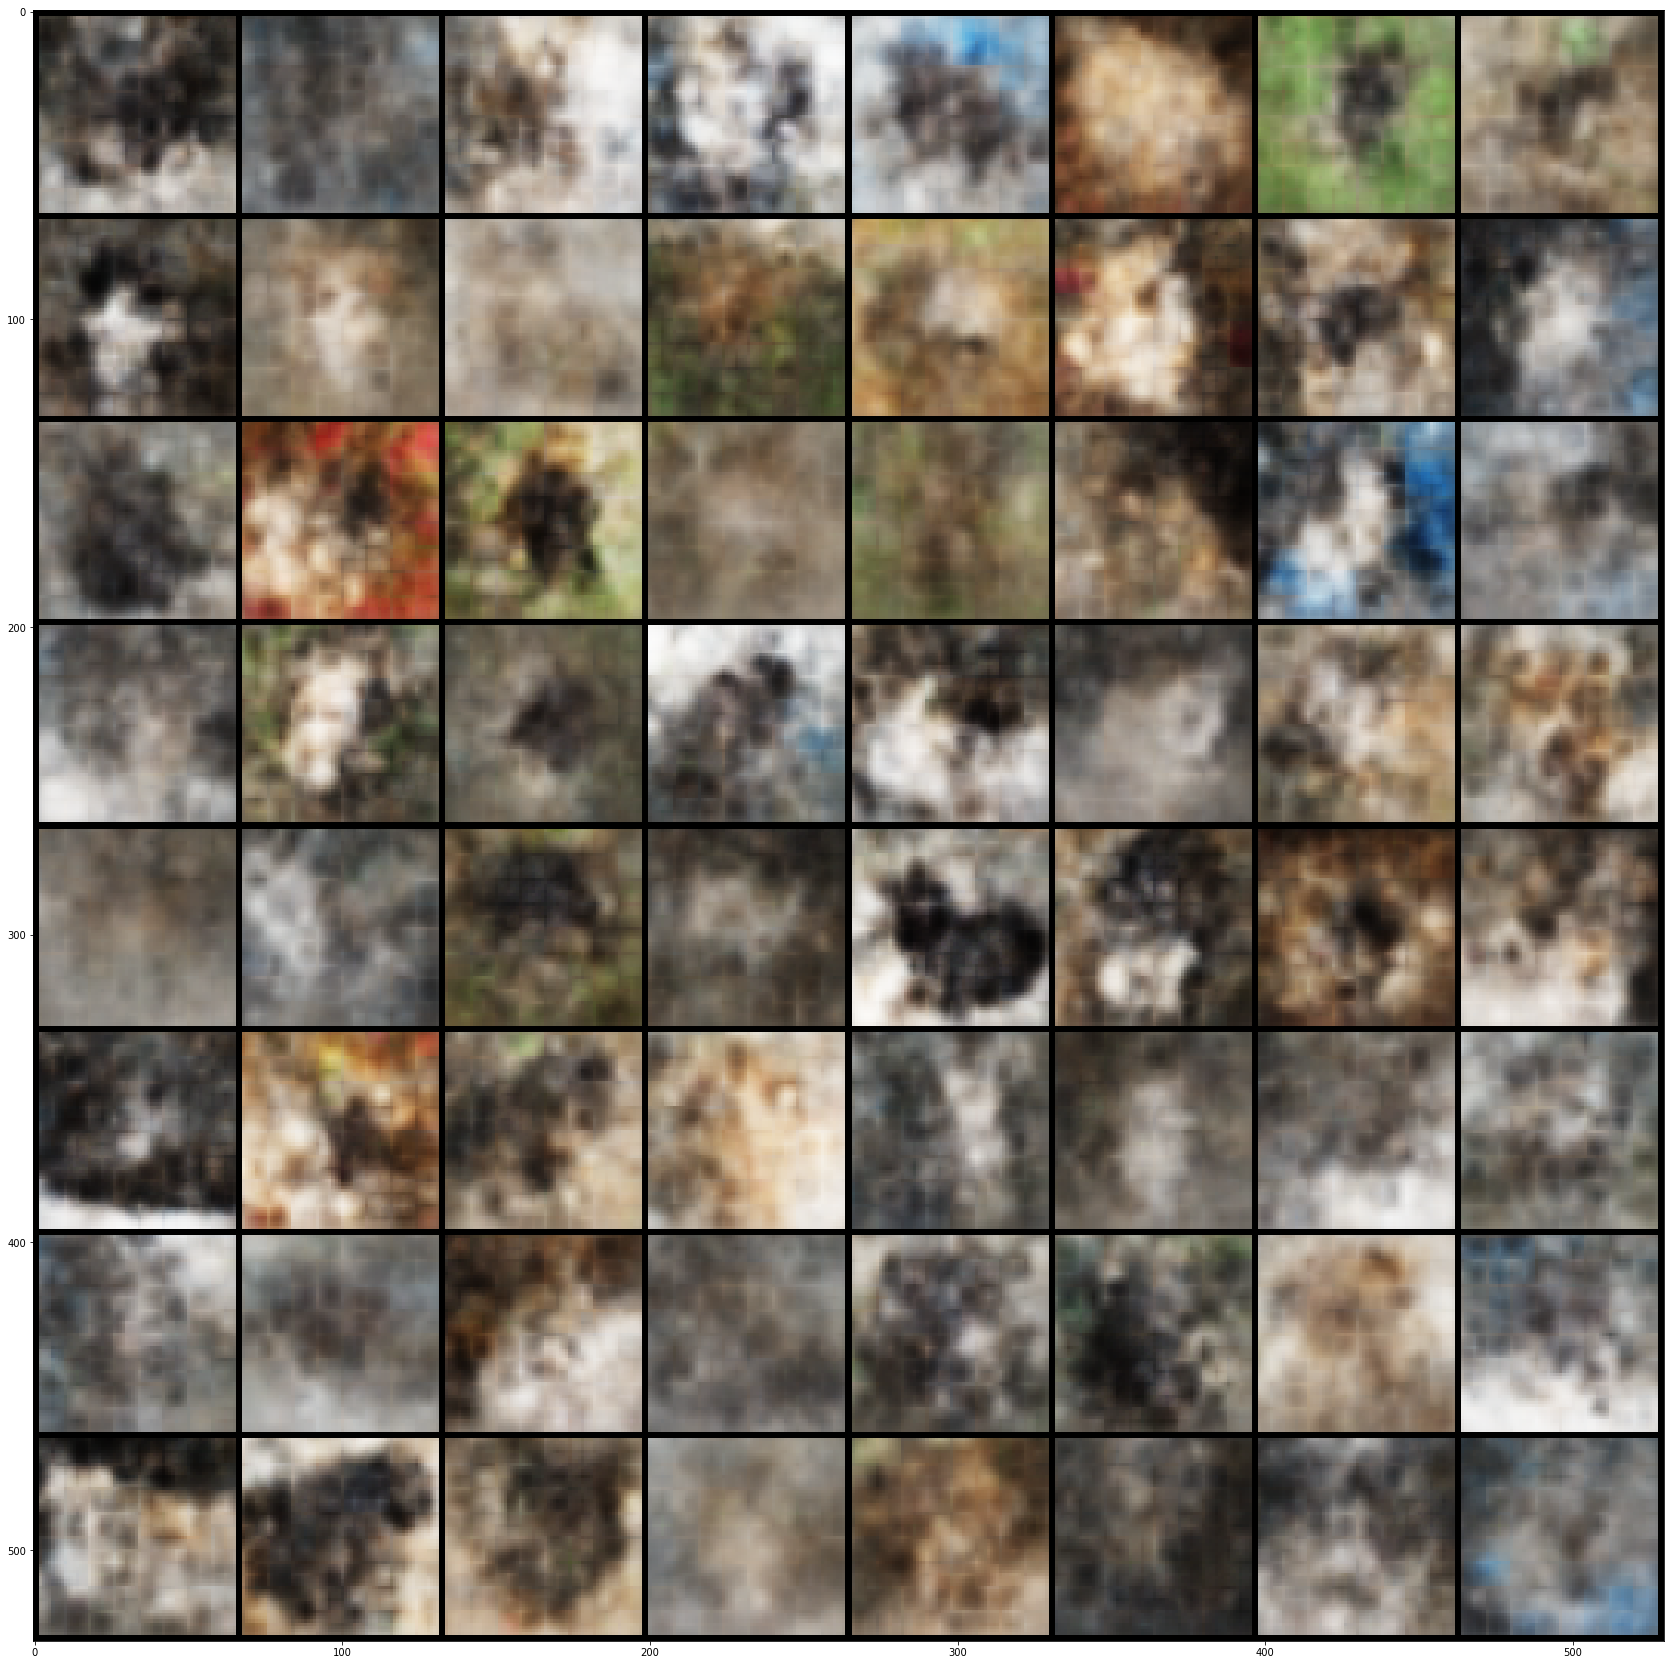

In [120]:
model.eval()
soft_labels = 0.2
sample = model.sample(64).detach().cpu()
#log_img = make_grid(sample.view(-1,3,img_size,img_size)*std_ds.view(1,3,1,1) + mean_ds.view(1,3,1,1)).permute((1,2,0)) #if image was normalized
plt.figure(figsize=(30,30))
plt.imshow(make_grid(sample.view(-1,3,img_size,img_size)).permute((1,2,0)))
#артефакты все портят

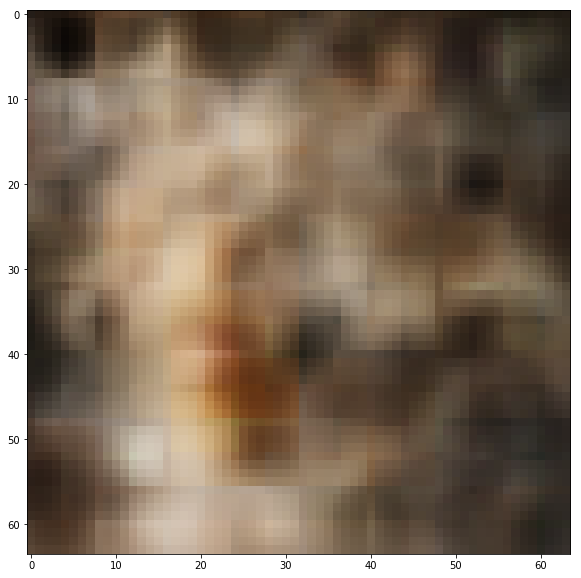

In [79]:
plt.figure(figsize=(10,10))
plt.imshow(sample[0].permute(1,2,0))

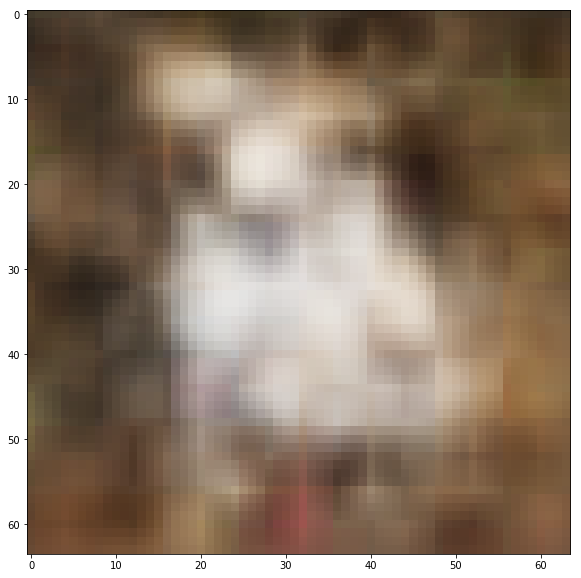

In [106]:
plt.figure(figsize=(10,10))
plt.imshow(sample[16].permute(1,2,0))

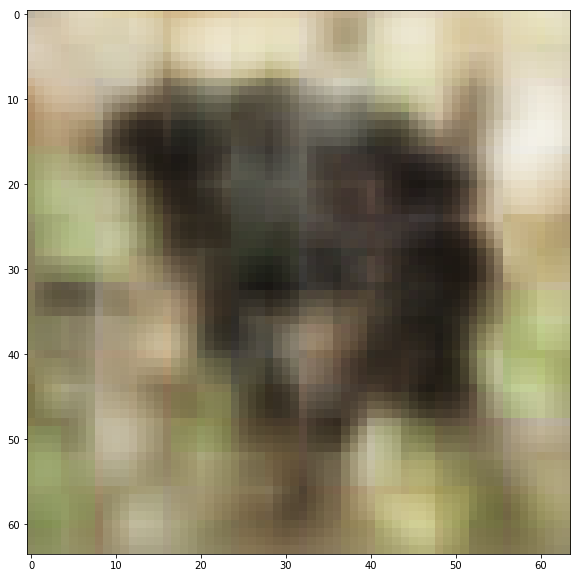

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(sample[27].permute(1,2,0))

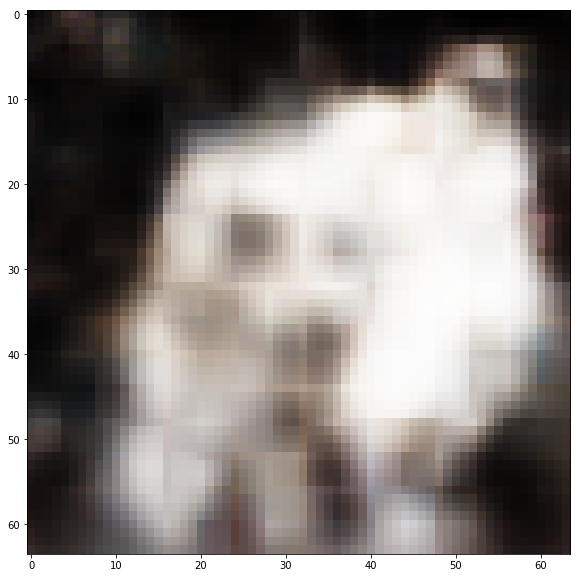

In [114]:
plt.figure(figsize=(10,10))
plt.imshow(sample[11].permute(1,2,0))

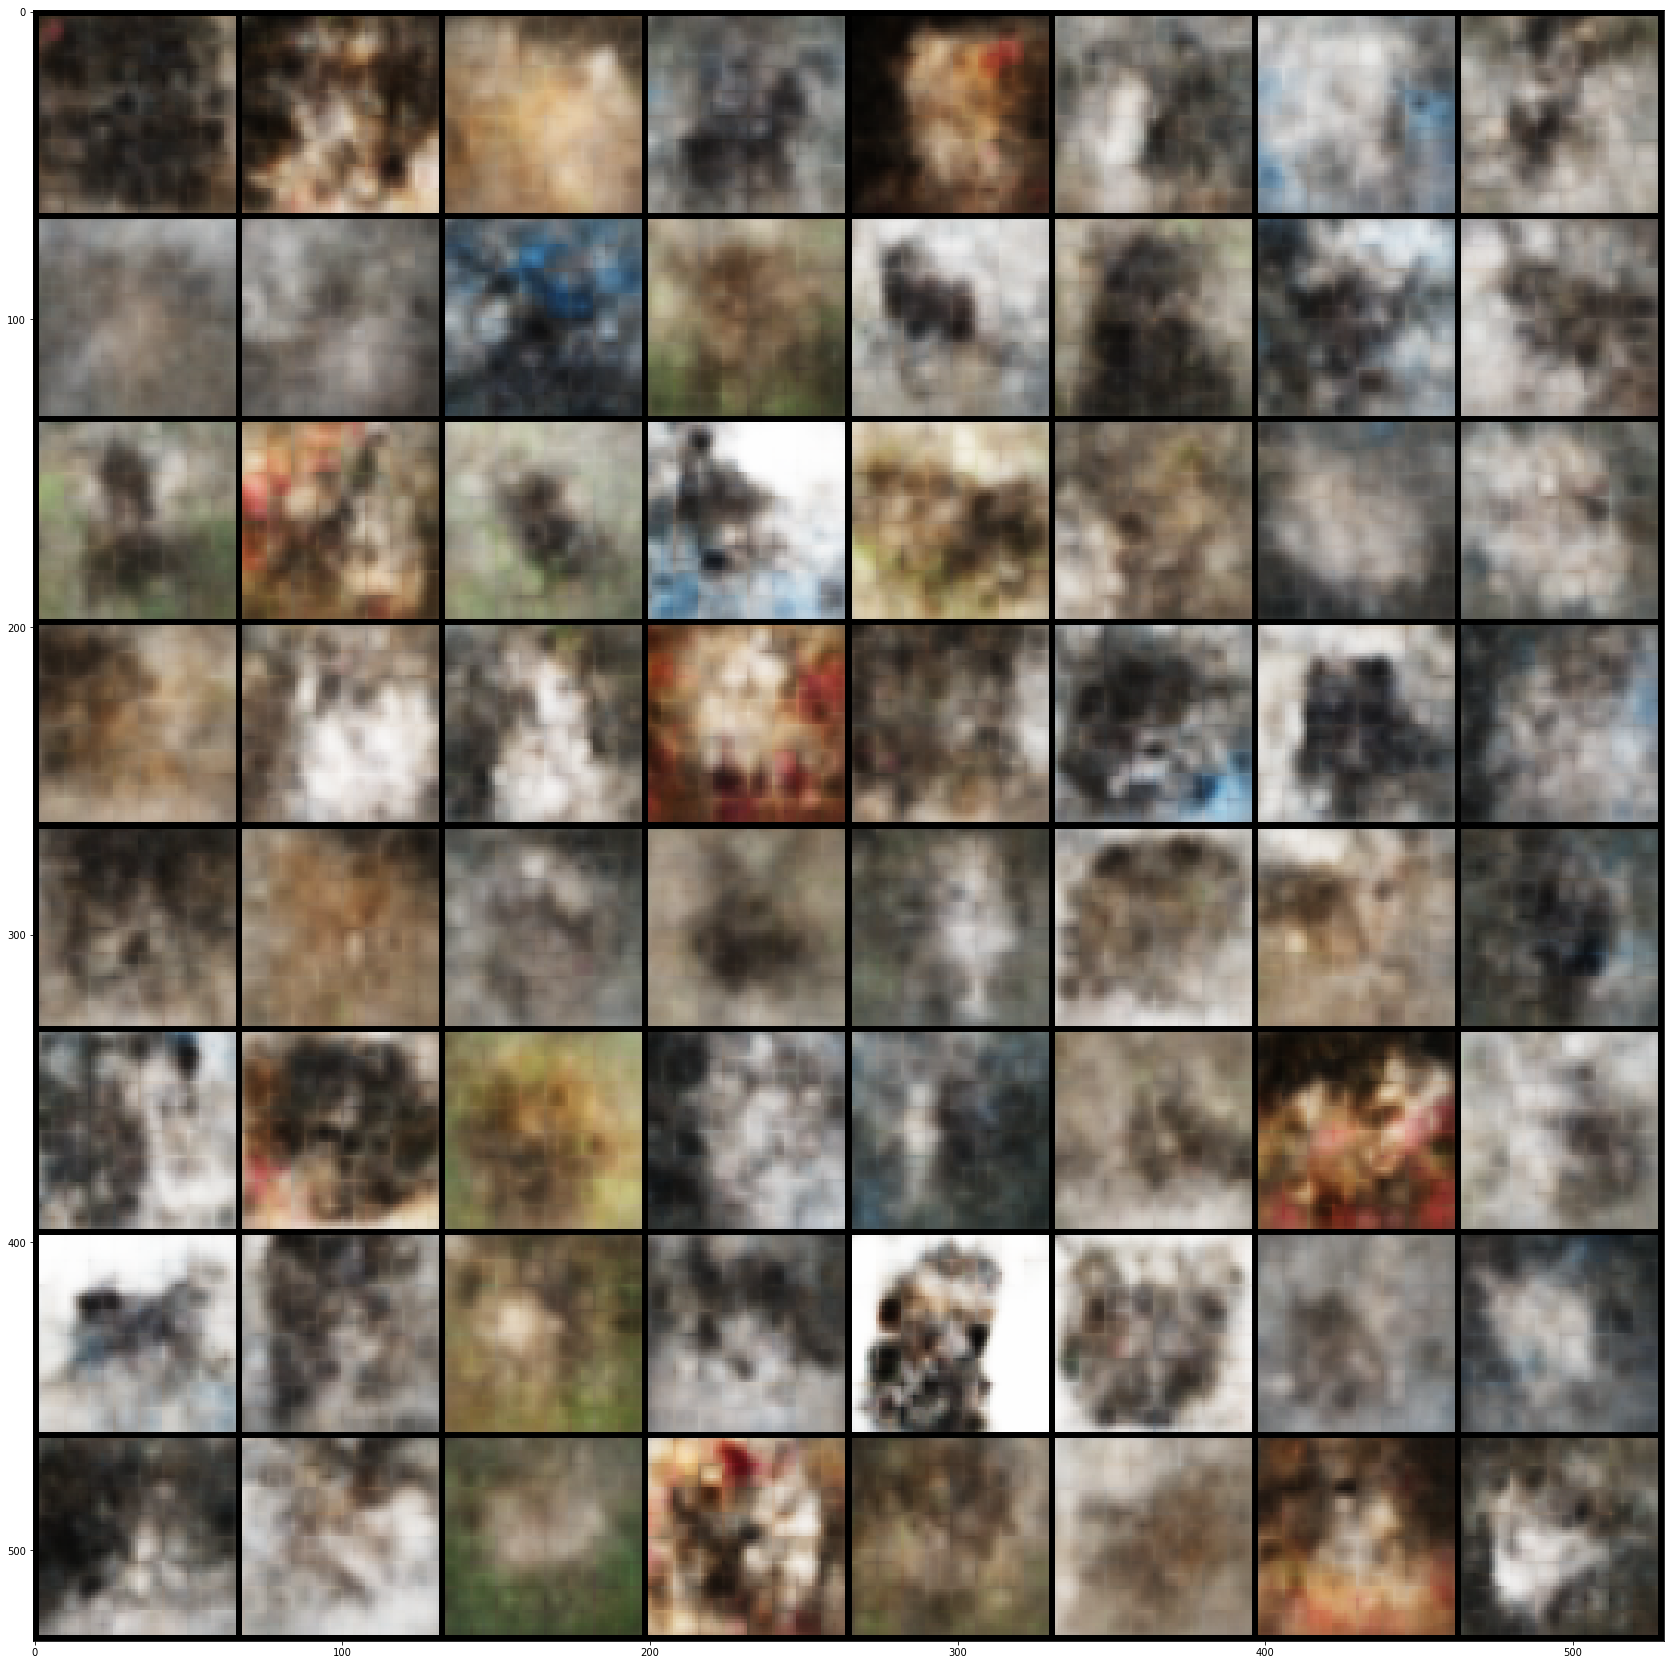

In [122]:
model = model = torch.load("final_model.pt")
model.eval()
soft_labels = 0.2
sample = model.sample(64).detach().cpu()
#log_img = make_grid(sample.view(-1,3,img_size,img_size)*std_ds.view(1,3,1,1) + mean_ds.view(1,3,1,1)).permute((1,2,0)) #if image was normalized
plt.figure(figsize=(30,30))
plt.imshow(make_grid(sample.view(-1,3,img_size,img_size)).permute((1,2,0)))
#артефакты все портят

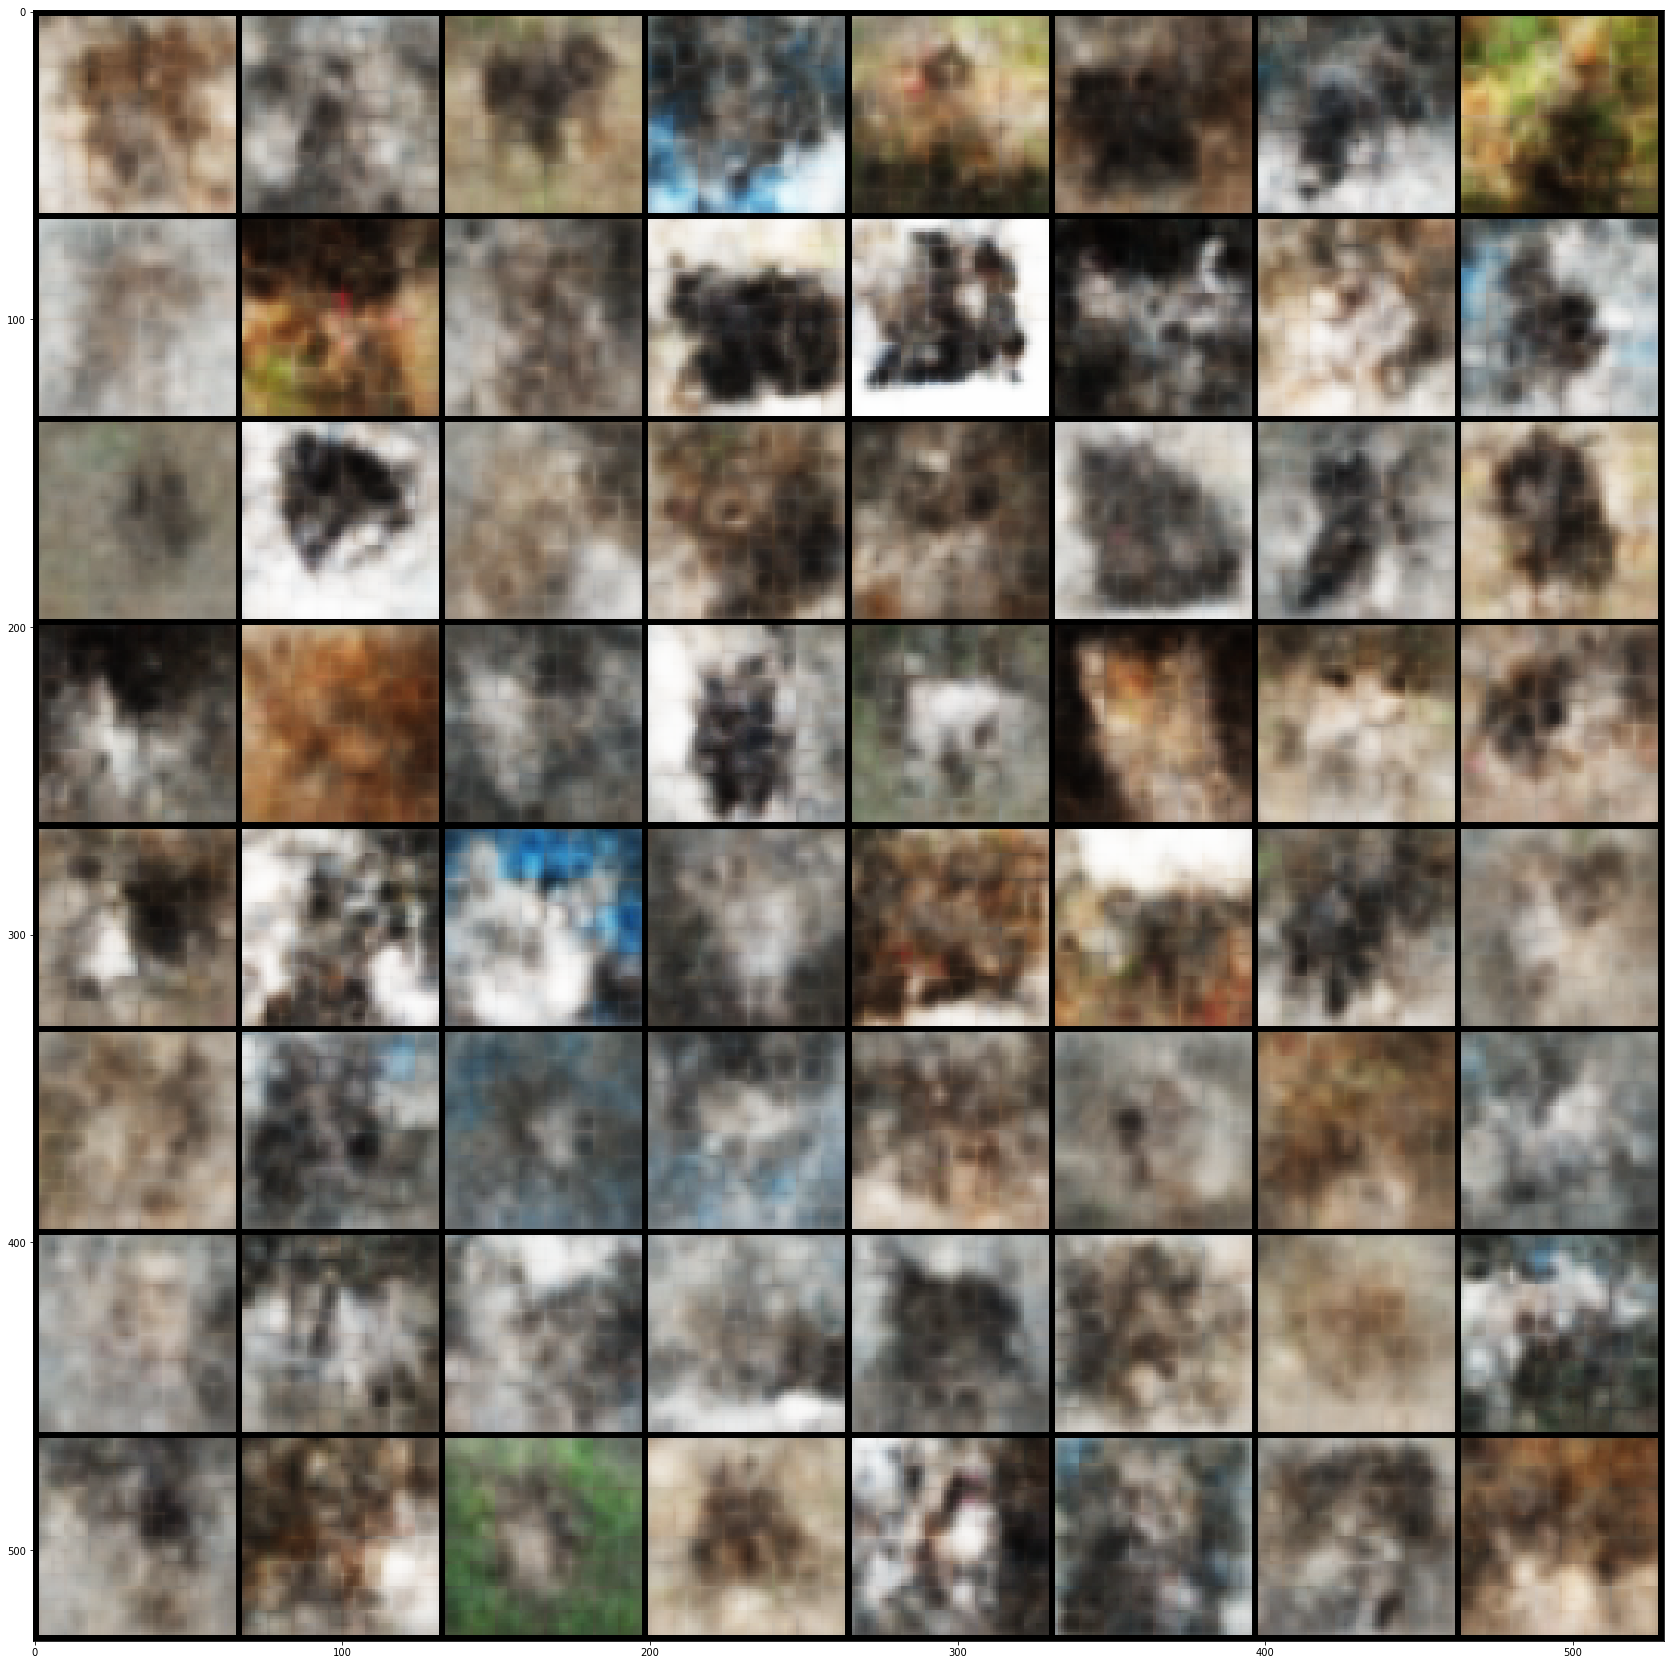

In [123]:
model = model = torch.load("final_model_1.pt")
model.eval()
soft_labels = 0.2
sample = model.sample(64).detach().cpu()
#log_img = make_grid(sample.view(-1,3,img_size,img_size)*std_ds.view(1,3,1,1) + mean_ds.view(1,3,1,1)).permute((1,2,0)) #if image was normalized
plt.figure(figsize=(30,30))
plt.imshow(make_grid(sample.view(-1,3,img_size,img_size)).permute((1,2,0)))
#артефакты все портят

In [121]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x,x,reduction = "sum")
    #BCE  = F.binary_cross_entropy(recon_x,x, reduction = "sum")
    KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


# СРАВНЕНИЕ МОДЕЛЕЙ С СОФТ-ЛЕЙБЛИНГОМ И БЕЗ НЕГО

Сравним модели обученные с софт-лейблингом и без него. Обе модели имеют идентичную архитектуру, обучались 20 эпох. Первая модель, обученная без софт-лейблинга:

In [125]:
def compute_loss():
    test_loss = 0
    for idx, batch in enumerate(dataloader):
        img = batch["image"].cuda()
        lbl = batch["label"].float().cuda()
        recon_x, mu, logvar = model(img,lbl)
        recon_x = recon_x.view(-1,3*img_size**2)
        loss = loss_function(recon_x, img.view(-1,3*img_size**2), mu, logvar)
        test_loss += loss.item()
    print(test_loss / len(dataloader.dataset))

In [126]:
model = torch.load("../input/vaepretraineda/model_64x64_40epoch_20_0soft_labeling.pt")

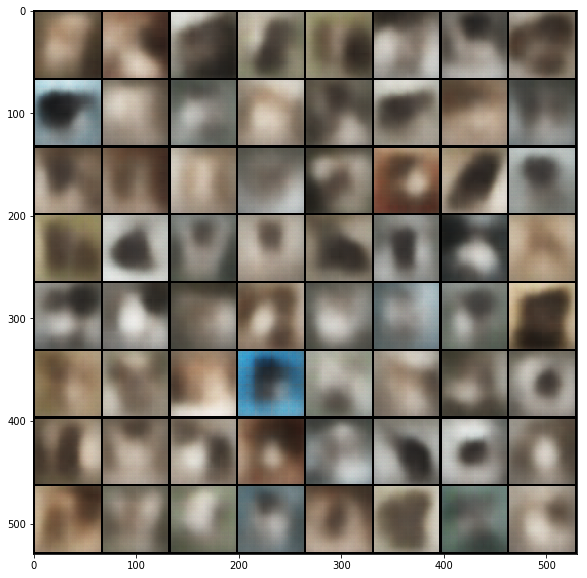

In [127]:
model.eval()
sample = model.sample(64).detach().cpu()
#log_img = make_grid(sample.view(-1,3,img_size,img_size)*std_ds.view(1,3,1,1) + mean_ds.view(1,3,1,1)).permute((1,2,0)) #if image was normalized
plt.figure(figsize=(20,10))
plt.imshow(make_grid(sample.view(-1,3,img_size,img_size)).permute((1,2,0)))

In [128]:
compute_loss()

329.29023703125


Вторая модель - модель обученная с софт-лейблингом (классы вида [0.2,0.8])

In [129]:
model = torch.load("../input/vaepretrained02/model_64x64_40epoch_20_02soft_labeling.pt")

Сэмплы с софт-лейблами:

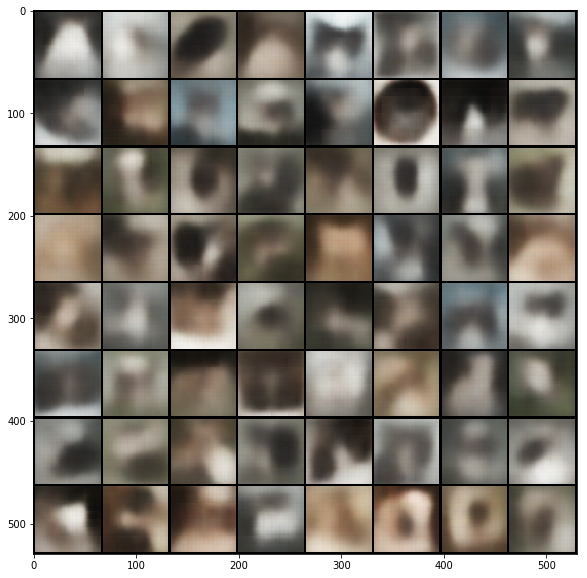

In [130]:
soft_labels = 0.2
model.eval()
sample = model.sample(64).detach().cpu()
plt.figure(figsize=(20,10))
plt.imshow(make_grid(sample.view(-1,3,img_size,img_size)).permute((1,2,0)))

Сэмплы с хард-леблами:

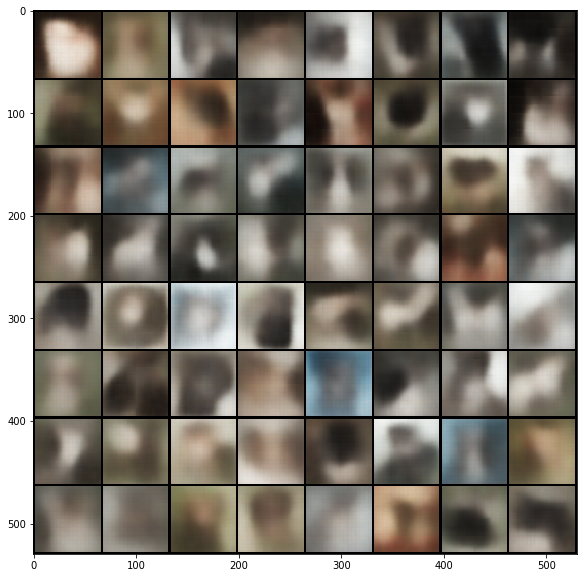

In [131]:
soft_labels = 0.
model.eval()
sample = model.sample(64).detach().cpu()
plt.figure(figsize=(20,10))
plt.imshow(make_grid(sample.view(-1,3,img_size,img_size)).permute((1,2,0)))

Лосс:

In [133]:
compute_loss()

295.8177422265625


Визуально довольно трудно сказать, дает ли софт-лейбелинг преимущества при обучении, но если судить по лоссу, то лосс в случае софт-лейблинга значительно ниже (295 vs 329) при той же архитектуре и той же продолжительности обучения. 

# Баллы
* Правильно написанный датасет - 1 балл
* Правильно реализованная модель VAE - 2 балла
* Написан код для обучения, модель чему-то обучается - 2 балла
* ВАЕ семплит адекватные картинки - 2 балла
* Проверено, насколько софт-лейблинг докидывает или не докидывает к качеству модели - 2 балла
* Получился котопёс - 1 балл

# Links

[C-VAE](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/)